In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from bs4 import BeautifulSoup as soup
import requests
from lxml import html
import folium
import seaborn as sn
import calendar

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path2 = "/content/drive/My Drive/California Wildfire Predictor/Data/California_Fires.csv"
CF = pd.read_csv(path2)
CF['Started'] = pd.to_datetime(CF['Started']).dt.strftime('%Y-%m-%d')
CF['Extinguished'] = pd.to_datetime(CF['Extinguished']).dt.strftime('%Y-%m-%d')
CF.head()

,AcresBurned,Active,AdminUnit,AirTankers,ArchiveYear,CalFireIncident,CanonicalUrl,ConditionStatement,ControlStatement,Counties,CountyIds,CrewsInvolved,Dozers,Engines,Extinguished,Fatalities,Featured,Final,FuelType,Helicopters,Injuries,Latitude,Location,Longitude,MajorIncident,Name,PercentContained,PersonnelInvolved,Public,SearchDescription,SearchKeywords,Started,Status,StructuresDamaged,StructuresDestroyed,StructuresEvacuated,StructuresThreatened,UniqueId,Updated,WaterTenders
0,257314.0,False,Stanislaus National Forest/Yosemite National Park,NaN,2013,True,/incidents/2013/8/17/rim-fire/,NaN,NaN,Tuolumne,55,NaN,NaN,NaN,2013-09-06,NaN,False,True,NaN,NaN,NaN,37.857000,3 miles east of Groveland along Hwy 120,-120.086000,False,Rim Fire,100.0,NaN,True,The Rim Fire was east of Groveland along Highw...,"Rim Fire, Stanislaus National Forest, Yosemite...",2013-08-17,Finalized,NaN,NaN,NaN,NaN,5fb18d4d-213f-4d83-a179-daaf11939e78,2013-09-06T18:30:00Z,NaN
1,30274.0,False,USFS Angeles National Forest/Los Angeles Count...,NaN,2013,True,/incidents/2013/5/30/powerhouse-fire/,NaN,NaN,Los Angeles,19,NaN,NaN,NaN,2013-06-08,NaN,False,True,NaN,NaN,NaN,34.585595,Angeles National Forest,-118.423176,False,Powerhouse Fire,100.0,NaN,True,The Powerhouse Fire burned in May and June 201...,"Powerhouse Fire, May 2013, June 2013, Angeles ...",2013-05-30,Finalized,NaN,NaN,NaN,NaN,bf37805e-1cc2-4208-9972-753e47874c87,2013-06-08T18:30:00Z,NaN
2,27531.0,False,CAL FIRE Riverside Unit / San Bernardino Natio...,NaN,2013,True,/incidents/2013/7/15/mountain-fire/,NaN,NaN,Riverside,33,NaN,NaN,NaN,2013-07-30,NaN,False,True,NaN,NaN,NaN,33.709500,Hwy 243 & Hwy 74 near Mountain Center,-116.728850,False,Mountain Fire,100.0,NaN,True,The Mountain Fire burned in July 2013 off High...,"Mountain Fire, July 2013, Highway 243, Highway...",2013-07-15,Finalized,NaN,NaN,NaN,NaN,a3149fec-4d48-427c-8b2c-59e8b79d59db,2013-07-30T18:00:00Z,NaN
3,27440.0,False,Tahoe National Forest,NaN,2013,False,/incidents/2013/8/10/american-fire/,NaN,NaN,Placer,31,NaN,NaN,NaN,2013-08-30,NaN,False,True,NaN,NaN,NaN,39.120000,"Deadwood Ridge, northeast of Foresthill",-120.650000,False,American Fire,100.0,NaN,True,The American Fire burned in August 2013 off De...,"American Fire, August 2013, Deadwood Ridge, Fo...",2013-08-10,Finalized,NaN,NaN,NaN,NaN,8213f5c7-34fa-403b-a4bc-da2ace6e6625,2013-08-30T08:00:00Z,NaN
4,24251.0,False,Ventura County Fire/CAL FIRE,NaN,2013,True,/incidents/2013/5/2/springs-fire/,Acreage has been reduced based upon more accur...,NaN,Ventura,56,47.0,8.0,117.0,2013-05-11,NaN,False,True,NaN,11.0,10.0,0.000000,Southbound Highway 101 at Camarillo Springs Ro...,0.000000,True,Springs Fire,100.0,2167.0,True,"The Springs Fire burned in May 2013, Southboun...","Springs Fire, May 2013, Highway 101, Camarillo...",2013-05-02,Finalized,6.0,10.0,NaN,NaN,46731fb8-3350-4920-bdf7-910ac0eb715c,2013-05-11T06:30:00Z,11.0


In [ ]:
path4 = "/content/drive/My Drive/California Wildfire Predictor/Data/counties.tsv"
counties = pd.read_csv(path4, sep='\t')
counties = counties[[counties.columns[3], counties.columns[-2], counties.columns[-1]]]
counties.columns = ['Name', 'Latitude2', 'Longitude2']
counties['Name'] = counties['Name'].str.replace(' County', '')
counties.head()

,Name,Latitude2,Longitude2
0,Alameda,37.647139,-121.912488
1,Alpine,38.621783,-119.798352
2,Amador,38.443550,-120.653856
3,Butte,39.665959,-121.601919
4,Calaveras,38.183900,-120.561441


In [ ]:
CF = CF.merge(counties, how='left', left_on='Counties', right_on='Name')
#Replacing 1969 fires with correct dates
CF.loc[1019,"Started"] = "2017-05-19"
CF.loc[1261,"Started"] = "2018-08-08"
CF.loc[1019,"Extinguished"] = "2017-05-19"
CF.loc[1261,"Extinguished"] = "2018-08-09"
#CF.head()

In [ ]:
new_lat = np.where(CF['Latitude'] == CF['Longitude'], CF['Latitude2'], CF['Latitude'])
new_long = np.where(CF['Latitude'] == CF['Longitude'], CF['Longitude2'], CF['Longitude'])
CF['Latitude'] = new_lat
CF['Longitude'] = new_long

In [ ]:
path3 = "/content/drive/My Drive/California Wildfire Predictor/Data/Station_List.csv"
Station_Ids = pd.read_csv(path3)
Station_Ids = Station_Ids[["Station Number", "Name", "County", "Latitude", "Longitude", "Status"]]
Station_Ids = Station_Ids.rename(columns = {"Station Number":"Station Id","Name":"Station Name"})
Station_Ids.head()

,Station Id,Station Name,County,Latitude,Longitude,Status
0,1.0,Fresno/F.S.U. USDA,Fresno,36.814000,-119.732000,Inactive
1,2.0,Five Points,Fresno,36.336222,-120.112906,Active
2,3.0,Beach /Santa Cruz CO,Santa Cruz,36.881000,-121.793000,Inactive
3,4.0,Webb /Santa Cruz CO,Santa Cruz,36.972000,-121.726000,Inactive
4,5.0,Shafter/USDA,Kern,35.532695,-119.281862,Active


In [ ]:
path = "/content/drive/My Drive/California Wildfire Predictor/Data/merged.csv"
merged_weather = pd.read_csv(path)
merged_weather.head()

,Station Id,Date,Julian Date,Reference Eto,QC for Reference Eto,Precipitation,QC for Precipitation,Solar Radiation Average,QC for Solar Radiation Average,Average Vapor Pressure,QC for Average Vapor Pressure,Maximum Air Temperature,QC for Maximum Air Temperature,Minimum Air Temperature,QC for Minimum Air Temperature,Average Air Temperature,QC for Average Air Temperature,Maximum Relative Humidity,QC for Maximum Relative Humidity,Minimum Relative Humidity,QC for Minimum Relative Humidity,Average Relative Humidity,QC for Average Relative Humidity,Dew Point,QC for Dew Point,Average Wind Speed,QC for Average Wind Speed,Wind Run,QC for Wind Run,Average Soil Temperature,QC for Average Soil Temperature
0,2,1/1/13,1,*,205,*,47.6,*,51,*,30,*,39.8,*,6.4,*,4.7,*,0,*,92,*,55,*,0.05,*,77,*,33.1,*,113.9
1,2,1/2/13,2,*,233,*,47,*,55.4,*,26.9,*,38.6,*,6.1,*,3,*,0,*,92,*,48,*,0.05,*,76,*,31.9,*,71.9
2,2,1/3/13,3,*,231,*,46.4,*,55.6,*,25.8,*,38.6,*,6,*,3,*,0,*,93,*,48,*,0.05,*,75,*,31.4,*,71.4
3,2,1/4/13,4,*,220,*,46.1,*,55.4,*,27.1,*,40.2,*,6.5,*,3,*,0,*,94,*,52,*,0.05,*,77,*,33.5,*,72.3
4,2,1/5/13,5,*,189,*,46.3,*,55.2,*,30.3,*,43,*,7.5,*,4.2,*,0.18,*,95,*,56,*,0.04,*,80,*,37.1,*,102.3


In [ ]:
final_weather = pd.merge(left = merged_weather, right = Station_Ids, left_on = ["Station Id"], right_on = ["Station Id"], how = "left")
final_weather['Date'] = pd.to_datetime(final_weather['Date'])
final_weather.head()

,Station Id,Date,Julian Date,Reference Eto,QC for Reference Eto,Precipitation,QC for Precipitation,Solar Radiation Average,QC for Solar Radiation Average,Average Vapor Pressure,QC for Average Vapor Pressure,Maximum Air Temperature,QC for Maximum Air Temperature,Minimum Air Temperature,QC for Minimum Air Temperature,Average Air Temperature,QC for Average Air Temperature,Maximum Relative Humidity,QC for Maximum Relative Humidity,Minimum Relative Humidity,QC for Minimum Relative Humidity,Average Relative Humidity,QC for Average Relative Humidity,Dew Point,QC for Dew Point,Average Wind Speed,QC for Average Wind Speed,Wind Run,QC for Wind Run,Average Soil Temperature,QC for Average Soil Temperature,Station Name,County,Latitude,Longitude,Status
0,2,2013-01-01,1,*,205,*,47.6,*,51,*,30,*,39.8,*,6.4,*,4.7,*,0,*,92,*,55,*,0.05,*,77,*,33.1,*,113.9,Five Points,Fresno,36.336222,-120.112906,Active
1,2,2013-01-02,2,*,233,*,47,*,55.4,*,26.9,*,38.6,*,6.1,*,3,*,0,*,92,*,48,*,0.05,*,76,*,31.9,*,71.9,Five Points,Fresno,36.336222,-120.112906,Active
2,2,2013-01-03,3,*,231,*,46.4,*,55.6,*,25.8,*,38.6,*,6,*,3,*,0,*,93,*,48,*,0.05,*,75,*,31.4,*,71.4,Five Points,Fresno,36.336222,-120.112906,Active
3,2,2013-01-04,4,*,220,*,46.1,*,55.4,*,27.1,*,40.2,*,6.5,*,3,*,0,*,94,*,52,*,0.05,*,77,*,33.5,*,72.3,Five Points,Fresno,36.336222,-120.112906,Active
4,2,2013-01-05,5,*,189,*,46.3,*,55.2,*,30.3,*,43,*,7.5,*,4.2,*,0.18,*,95,*,56,*,0.04,*,80,*,37.1,*,102.3,Five Points,Fresno,36.336222,-120.112906,Active


In [ ]:
def closest_station(fire_lat, fire_lon, stations):
  stations['Distance'] = ((stations['Latitude'] - fire_lat)**2 + (stations['Longitude'] - fire_lon)**2)**.5
  stations_sort = stations.sort_values('Distance', ascending=True)
  return int(stations_sort['Station Id'].iloc[0])

In [ ]:
def days_ago(date, ago):
  split_date = date.split('-')
  final_year = split_date[0]
  year =  [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
  if final_year in ['2012', '2016', '2020']:
    year[2] = 29
  day = sum(year[:int(split_date[1])]) + int(split_date[2])
  day_ago = day - ago
  if day_ago < 0:
    final_year = str(int(final_year) - 1)
    if year[2] == 29:
      year[2] = 28
    day_ago = sum(year) + day_ago
  for i in range(len(year)):
    if day_ago > year[i+1]:
      day_ago = day_ago - year[i+1]
      continue
    else:
      return final_year + '-' + str(i+1) + '-' + str(day_ago)

In [ ]:
def find_weather_data(weather, fire, days):
  fire_started = fire['Started']
  days_before = days_ago(fire_started, days)
  dated_weather = weather[(weather['Date'] <= fire_started) & (final_weather['Date'] > days_before)]
  stations = dated_weather[['Station Id', 'Latitude', 'Longitude']]
  weather_station = closest_station(fire['Latitude'], fire['Longitude'], stations)
  return dated_weather[dated_weather['Station Id'] == weather_station]

In [ ]:
def fires_last_year(fire):
  start = fire['Started']
  last_year = CF[(CF['Started'] < start) & (CF['Started'] >= days_ago(start, 365))]
  last_year = last_year[last_year['Counties'] == fire['Counties']]
  return len(last_year)

In [ ]:
x = find_weather_data(final_weather, CF.iloc[300], 60)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
x.head()

,Station Id,Date,Julian Date,Reference Eto,QC for Reference Eto,Precipitation,QC for Precipitation,Solar Radiation Average,QC for Solar Radiation Average,Average Vapor Pressure,QC for Average Vapor Pressure,Maximum Air Temperature,QC for Maximum Air Temperature,Minimum Air Temperature,QC for Minimum Air Temperature,Average Air Temperature,QC for Average Air Temperature,Maximum Relative Humidity,QC for Maximum Relative Humidity,Minimum Relative Humidity,QC for Minimum Relative Humidity,Average Relative Humidity,QC for Average Relative Humidity,Dew Point,QC for Dew Point,Average Wind Speed,QC for Average Wind Speed,Wind Run,QC for Wind Run,Average Soil Temperature,QC for Average Soil Temperature,Station Name,County,Latitude,Longitude,Status
142228,195,2015-05-27,147,0.24,,0,,688,,11.9,,85.2,,49.5,,67.2,,88,,25,,52,,49,,2.7,,65.7,,72.9,,Auburn,Placer,38.887603,-121.102908,Active
142229,195,2015-05-28,148,0.23,,0,,617,,12.7,,85.8,,52.9,,70.2,,80,,30,,50,,50.9,,3.2,,76.1,,73.3,,Auburn,Placer,38.887603,-121.102908,Active
142230,195,2015-05-29,149,0.25,,0,,630,,12.3,,92,,61.3,,74.6,,61,,15,,42,,50,,3.6,,86.7,,74.2,,Auburn,Placer,38.887603,-121.102908,Active
142231,195,2015-05-30,150,0.27,,0,,674,,10.9,,92.9,,63.7,,76.4,,60,,14,,35,,46.7,,3.5,,82.8,,75.2,,Auburn,Placer,38.887603,-121.102908,Active
142232,195,2015-05-31,151,0.22,,0,,548,,9.5,,83.4,,54.7,,71,,68,,20,,37,,43.2,,3.4,,81.2,,74.8,,Auburn,Placer,38.887603,-121.102908,Active


In [ ]:
%%capture --no-stdout

rows_list = []
for i in range(len(CF[CF['Started'] >= '2014-03-01'])):
  fire = CF[CF['Started'] >= '2014-03-01'].iloc[i]
  weather_data = find_weather_data(final_weather, fire, 60)
  weather_data['Precipitation'] = np.where(weather_data['Precipitation'] == '--', 0, weather_data['Precipitation'])
  weather_data['Maximum Air Temperature '] = np.where(weather_data['Maximum Air Temperature '] == '--', 0, weather_data['Maximum Air Temperature '])
  weather_data['Minimum Relative Humidity '] = np.where(weather_data['Minimum Relative Humidity '] == '--', 0, weather_data['Minimum Relative Humidity '])
  weather_data['Average Wind Speed '] = np.where(weather_data['Average Wind Speed '] == '--', 0, weather_data['Average Wind Speed '])
  total_precip = 0
  for i in range(len(weather_data)):
    total_precip += (((i+1)/len(weather_data)) * float(weather_data['Precipitation'].iloc[i]))
  total_max_temp = 0
  for i in range(len(weather_data)):
    total_max_temp += (((i+1)/len(weather_data)) * float(weather_data['Maximum Air Temperature '].iloc[i]))
  total_min_hum = 0
  for i in range(len(weather_data)):
    total_min_hum += (((i+1)/len(weather_data)) * float(weather_data['Minimum Relative Humidity '].iloc[i]))
  total_avg_wind = 0
  for i in range(len(weather_data)):
    total_avg_wind += (((i+1)/len(weather_data)) * float(weather_data['Average Wind Speed '].iloc[i]))
  total_fires = fires_last_year(fire)
  feature_dict = {'AcresBurned':fire['AcresBurned'],'Started':fire['Started'],'Latitude':fire['Latitude'],'Longitude':fire['Longitude'],'precip':total_precip,'max_temp':total_max_temp,'min_hum':total_min_hum,'avg_wind':total_avg_wind,'fires_last_year':total_fires}
  rows_list.append(feature_dict)

features_df = pd.DataFrame(rows_list,columns=['AcresBurned', 'Started', 'Latitude', 'Longitude', 'precip', 'max_temp', 'min_hum', 'avg_wind', 'fires_last_year'])

In [ ]:
features_df.head()

,AcresBurned,Started,Latitude,Longitude,precip,max_temp,min_hum,avg_wind,fires_last_year
0,97717.0,2014-09-13,38.805437,-120.629714,0.115833,2654.298333,618.050000,178.521667,2
1,50042.0,2014-08-02,41.587986,-122.533287,0.000000,3054.145000,411.250000,117.853333,4
2,39736.0,2014-07-30,40.901000,-121.368000,0.070500,2699.308333,760.066667,155.416667,4
3,35302.0,2014-07-30,42.048000,-122.345000,0.141333,2554.151667,819.500000,147.843333,1
4,32496.0,2014-07-30,41.587986,-122.533287,0.000000,3026.240000,429.416667,117.560000,1


In [ ]:
features_df.sort_values('Started').head()

,AcresBurned,Started,Latitude,Longitude,precip,max_temp,min_hum,avg_wind,fires_last_year
62,125.0,2014-03-08,32.810000,-116.490000,0.000000,2378.066667,586.200000,92.983333,0
46,350.0,2014-03-15,33.729828,-116.002239,0.000000,2445.248333,622.733333,152.633333,0
43,400.0,2014-03-19,36.631300,-121.481900,0.652667,2102.616667,1503.666667,113.328333,0
85,57.0,2014-03-28,33.598200,-116.198500,0.000000,2502.498333,555.600000,176.173333,1
64,113.0,2014-04-19,37.399000,-118.352000,0.244333,2136.118333,392.283333,132.491667,0


In [ ]:
features_df.sort_values('AcresBurned', ascending=False).head(20)

,AcresBurned,Started,Latitude,Longitude,precip,max_temp,min_hum,avg_wind,fires_last_year
888,410203.0,2018-07-27,39.243283,-123.103367,0.019333,2548.873333,1211.366667,108.406667,2
887,410203.0,2018-07-27,39.243283,-123.103367,0.019333,2548.873333,1211.366667,108.406667,4
886,410203.0,2018-07-27,39.243283,-123.103367,0.019333,2548.873333,1211.366667,108.406667,3
885,410203.0,2018-07-27,39.243283,-123.103367,0.019333,2548.873333,1211.366667,108.406667,1
447,281893.0,2017-12-04,34.415210,-119.091240,0.012667,2433.283333,1132.583333,114.508333,4
448,281893.0,2017-12-04,34.415210,-119.091240,0.012667,2433.283333,1132.583333,114.508333,2
890,229651.0,2018-07-23,40.654280,-122.623570,0.016667,2977.518333,564.233333,113.220000,1
889,229651.0,2018-07-23,40.654280,-122.623570,0.016667,2977.518333,564.233333,113.220000,5
891,153336.0,2018-11-08,39.813400,-121.434700,0.274833,2459.531667,769.900000,88.426667,11
110,151623.0,2015-07-31,36.874000,-118.905000,0.028167,2943.811667,526.966667,164.216667,2


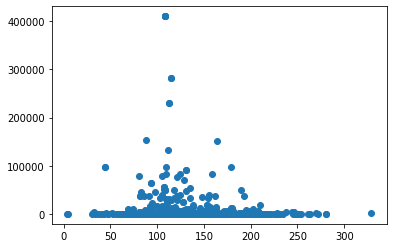

In [ ]:
plt.scatter(features_df['avg_wind'], features_df['AcresBurned'])

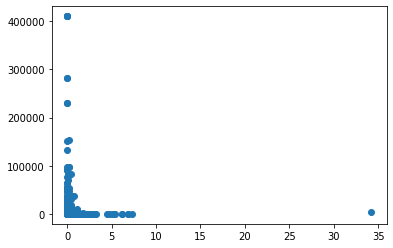

In [ ]:
plt.scatter(features_df['precip'], features_df['AcresBurned'])

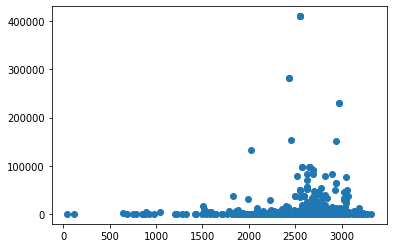

In [ ]:
plt.scatter(features_df['max_temp'], features_df['AcresBurned'])

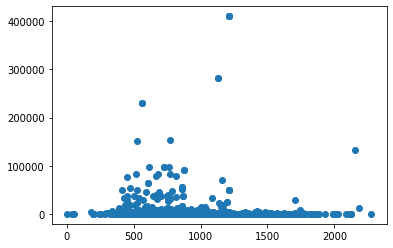

In [ ]:
plt.scatter(features_df['min_hum'], features_df['AcresBurned'])

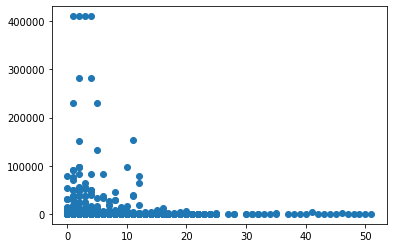

In [ ]:
plt.scatter(features_df['fires_last_year'], features_df['AcresBurned'])

[Text(0, 0, 'Jan'),
 Text(1, 0, 'Feb'),
 Text(2, 0, 'Mar'),
 Text(3, 0, 'Apr'),
 Text(4, 0, 'May'),
 Text(5, 0, 'Jun'),
 Text(6, 0, 'Jul'),
 Text(7, 0, 'Aug'),
 Text(8, 0, 'Sep'),
 Text(9, 0, 'Oct'),
 Text(10, 0, 'Nov'),
 Text(11, 0, 'Dec')]

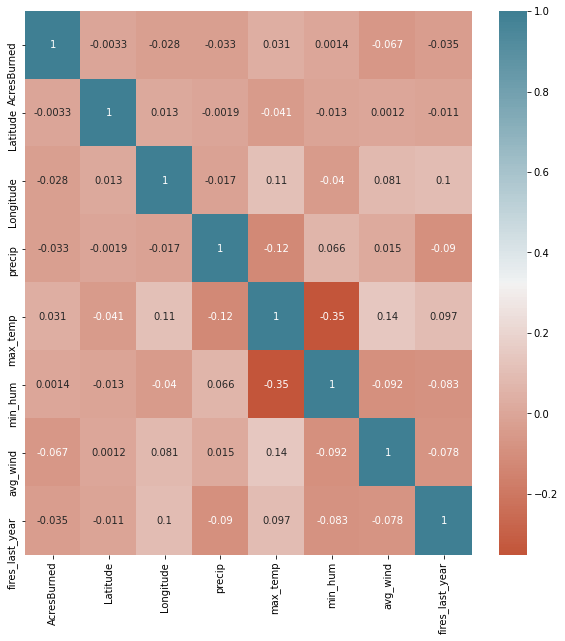

In [ ]:
#correlation matrix 
plt.rcParams["figure.figsize"]=10,10
corrMatrix = features_df.corr()
sn.heatmap(corrMatrix, annot=True, cmap=sn.diverging_palette(20, 220, n=200))
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right')

Text(0, 0.5, 'Number of Fires')

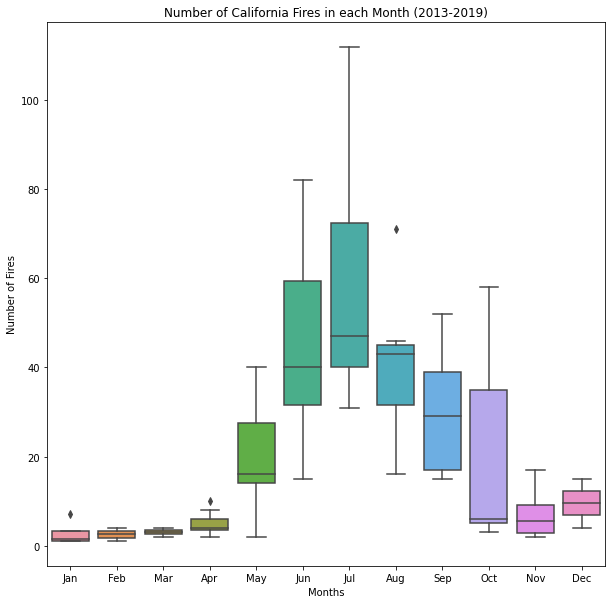

In [ ]:
CF["Started"] = pd.to_datetime(CF["Started"])
CF["Month"] = CF["Started"].dt.month
CF["Year"] = CF["Started"].dt.year
CF['Month'] = CF['Month'].apply(lambda x: calendar.month_abbr[x])
Year = CF.groupby("Year")
all_months = Year["Month"].value_counts()
plt.rcParams["figure.figsize"]= 10,10
all_months.index = all_months.index.droplevel()
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
all_months.index = pd.Categorical(all_months.index, categories=months, ordered=True)
merged_values = []
for value in all_months.values: 
  merged_values.append(value)
ax = sn.boxplot(x = all_months.index, y = merged_values)
ax.set_title('Number of California Fires in each Month (2013-2019)')
ax.set_xlabel('Months')
ax.set_ylabel('Number of Fires')


Text(0, 0.5, 'Acres Burne (in millions)')

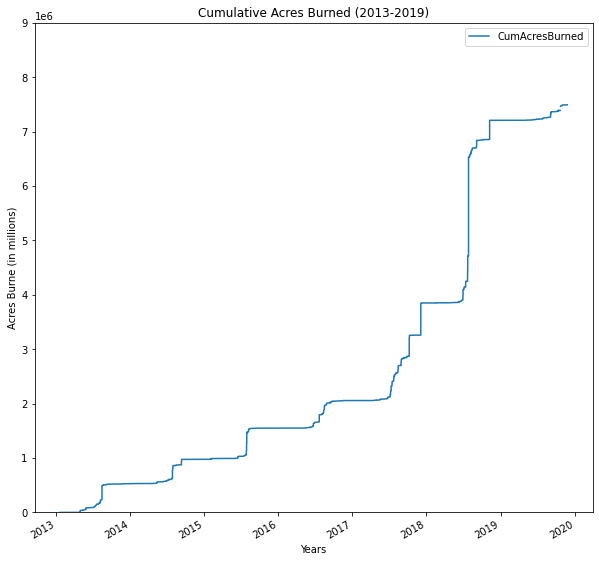

In [ ]:

CF_sorted = CF.sort_values('Started', ascending=True)
CF_sorted["CumAcresBurned"] = CF_sorted["AcresBurned"].cumsum()
ax = CF_sorted.plot.line(x = "Started", y = "CumAcresBurned")
ax.set_ylim([0,9000000])
ax.set_title('Cumulative Acres Burned (2013-2019)')
ax.set_xlabel('Years')
ax.set_ylabel('Acres Burne (in millions)')
#This clearly shows that 2018 was a peak year for burns. I am planning on doing a visualization on 2018 especially. 
